In [1]:
# Standard stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import pickle
from sklearn.preprocessing import StandardScaler

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.distributions import Categorical

# Algorithmic trading
import tpqoa
from datetime import datetime, timedelta
import time

# My designs
import agents
import environments
import models

In [2]:
def get_scaler(env, epochs):
    states = []

    for i in range(epochs):
        done = False
        while not done:   # play as random agent to generate sample space of states
            action = np.random.choice(env.action_space)
            state, reward, done, info = env.step(action)
            states.append(state)
    
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def play_one_episode(env, agent, scaler):
    state = env.reset()
    state = scaler.transform([state])
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        agent.train(state, action, reward, next_state, done)
        state = next_state
    
    return info["cur_val"]

def get_data(api, instrument, bar_length, months = 6):     
    now = datetime.utcnow()
    now = now - timedelta(microseconds = now.microsecond)
    past = now - timedelta(days = 30 * months)

    df_ask = api.get_history(
        instrument = instrument,
        start = past,
        end = now,
        granularity = "S5",
        price = "A",
        localize = False
    ).c.rename("Ask")

    df_ask = df_ask.resample(pd.to_timedelta(bar_length), label = "right").last()

    df_bid = api.get_history(
        instrument = instrument,
        start = past,
        end = now,
        granularity = "S5",
        price = "B",
        localize = False
    ).c.rename("Bid")

    df_bid = df_bid.resample(pd.to_timedelta(bar_length), label = "right").last()

    df = pd.concat([df_ask, df_bid], axis = 1).dropna().iloc[ : -1]
    return df


In [3]:
api = tpqoa.tpqoa("oanda.cfg")
balance = float(api.get_account_summary()["balance"])
balance

99872.6231

In [4]:
data = pd.read_csv("eur_usd_data.csv", index_col="time")
data

,Ask,Bid
time,,
2021-08-15 21:20:00+00:00,1.17983,1.17935
2021-08-15 21:40:00+00:00,1.17982,1.17926
2021-08-15 22:00:00+00:00,1.17965,1.17925
2021-08-15 22:20:00+00:00,1.17978,1.17962
2021-08-15 22:40:00+00:00,1.17953,1.17936
...,...,...
2022-02-10 13:00:00+00:00,1.14370,1.14357
2022-02-10 13:20:00+00:00,1.14332,1.14318
2022-02-10 13:40:00+00:00,1.14107,1.14091


In [5]:
df = data.copy()
df["returns"] = np.log(data["Ask"] / data["Ask"].shift())
df["dir"] = np.where(df["returns"] > 0 , 1, 0)
df["sma"] = df["Ask"].rolling(50).mean() - df["Ask"].rolling(150).mean()
df["boll"] = (df["Ask"] - df["Ask"].rolling(50).mean()) / df["Ask"].rolling(50).std()
df["min"] = df["Ask"].rolling(50).min() / df["Ask"] - 1
df["max"] = df["Ask"].rolling(50).max() / df["Ask"] - 1
df["mom"] = df["Ask"].rolling(3).mean()
df["vol"] = df["Ask"].rolling(50).std()
df.dropna(inplace = True)
df

,Ask,Bid,returns,dir,sma,boll,min,max,mom,vol
time,,,,,,,,,,
2021-08-17 23:00:00+00:00,1.17066,1.17053,0.000000,0,-0.003060,-1.106515,0.000000,0.006330,1.170670,0.002733
2021-08-17 23:20:00+00:00,1.17065,1.17052,-0.000009,0,-0.003115,-1.066457,0.000000,0.006338,1.170657,0.002736
2021-08-17 23:40:00+00:00,1.17088,1.17076,0.000196,1,-0.003162,-0.943842,-0.000196,0.006141,1.170730,0.002735
2021-08-18 00:00:00+00:00,1.17101,1.17087,0.000111,1,-0.003220,-0.860801,-0.000307,0.006029,1.170847,0.002713
2021-08-18 00:20:00+00:00,1.17136,1.17123,0.000299,1,-0.003275,-0.700043,-0.000606,0.005728,1.171083,0.002677
...,...,...,...,...,...,...,...,...,...,...
2022-02-10 13:00:00+00:00,1.14370,1.14357,0.000035,1,0.000253,1.211933,-0.001749,0.000630,1.143563,0.000702
2022-02-10 13:20:00+00:00,1.14332,1.14318,-0.000332,0,0.000266,0.644623,-0.001417,0.000962,1.143560,0.000702
2022-02-10 13:40:00+00:00,1.14107,1.14091,-0.001970,0,0.000247,-2.367965,0.000000,0.002936,1.142697,0.000746


In [6]:
lags = 5
cols = ["Ask", "Bid", "returns", "dir", "sma", "boll", "min", "max", "mom", "vol"]
features = ["dir", "sma", "boll", "min", "max", "mom", "vol"]

In [7]:
for f in features:
    for lag in range(1, lags + 1):
        col = "{}_lag_{}".format(f, lag)
        df[col] = df[f].shift(lag)
        cols.append(col)
df.dropna(inplace = True)
df

,Ask,Bid,returns,dir,sma,boll,min,max,mom,vol,...,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
time,,,,,,,,,,,,,,,,,,,,,
2021-08-18 00:40:00+00:00,1.17118,1.17105,-0.000154,0,-0.003342,-0.735367,-0.000453,0.005883,1.171183,0.002627,...,1.171083,1.170847,1.170730,1.170657,1.170670,0.002677,0.002713,0.002735,0.002736,0.002733
2021-08-18 01:00:00+00:00,1.17129,1.17115,0.000094,1,-0.003420,-0.663652,-0.000546,0.005788,1.171277,0.002545,...,1.171183,1.171083,1.170847,1.170730,1.170657,0.002627,0.002677,0.002713,0.002735,0.002736
2021-08-18 01:20:00+00:00,1.17132,1.17119,0.000026,1,-0.003500,-0.622914,-0.000572,0.005524,1.171263,0.002446,...,1.171277,1.171183,1.171083,1.170847,1.170730,0.002545,0.002627,0.002677,0.002713,0.002735
2021-08-18 01:40:00+00:00,1.17140,1.17124,0.000068,1,-0.003574,-0.560599,-0.000640,0.005259,1.171337,0.002347,...,1.171263,1.171277,1.171183,1.171083,1.170847,0.002446,0.002545,0.002627,0.002677,0.002713
2021-08-18 02:00:00+00:00,1.17172,1.17155,0.000273,1,-0.003628,-0.392488,-0.000913,0.004984,1.171480,0.002267,...,1.171337,1.171263,1.171277,1.171183,1.171083,0.002347,0.002446,0.002545,0.002627,0.002677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-10 13:00:00+00:00,1.14370,1.14357,0.000035,1,0.000253,1.211933,-0.001749,0.000630,1.143563,0.000702,...,1.143420,1.143403,1.143660,1.143800,1.143997,0.000695,0.000688,0.000685,0.000682,0.000677
2022-02-10 13:20:00+00:00,1.14332,1.14318,-0.000332,0,0.000266,0.644623,-0.001417,0.000962,1.143560,0.000702,...,1.143563,1.143420,1.143403,1.143660,1.143800,0.000702,0.000695,0.000688,0.000685,0.000682
2022-02-10 13:40:00+00:00,1.14107,1.14091,-0.001970,0,0.000247,-2.367965,0.000000,0.002936,1.142697,0.000746,...,1.143560,1.143563,1.143420,1.143403,1.143660,0.000702,0.000702,0.000695,0.000688,0.000685


In [8]:
len(cols)

45

In [9]:
train_sim = environments.Simulator(
        data = df, 
        initial_investment = balance,
        bar_length = "20min",
        time_horizon = "12hour",
        units = 100000
)

In [10]:
state_size = 47
model = models.ActorCriticNetwork(input_dim = state_size)
agent = agents.ActorCriticTrader(model = model, state_size = state_size)

In [11]:
x = train_sim.reset()

In [12]:
agent.model.predict(x.reshape(1,-1))

[array([0., 0., 1.], dtype=float32), array(1460.7496, dtype=float32)]

In [13]:
scaler = get_scaler(train_sim, 1)

In [14]:
model_folder = "day_trader_models"
rewards_folder = "day_trader_rewards"
num_episodes = 24
portfolio_value = []

maybe_make_dir(model_folder)
maybe_make_dir(rewards_folder)

In [15]:
for i in range(num_episodes):
    best_weights = []
    val = play_one_episode(env = train_sim, agent = agent, scaler = scaler)
    portfolio_value.append(val)
    if val == max(portfolio_value):
        best_weights = agent.model.get_weights()
    print("Completed episode {}, portfolio value {}".format(i+1, val))

Completed episode 1, portfolio value 86604.62310000019
Completed episode 2, portfolio value 87208.62310000058
Completed episode 3, portfolio value 81471.62310000118
Completed episode 4, portfolio value 76724.62310000115
Completed episode 5, portfolio value 61819.62310000238
Completed episode 6, portfolio value 48237.623100003286
Completed episode 7, portfolio value 46651.623100000696
Completed episode 8, portfolio value 78069.62310000106
Completed episode 9, portfolio value 88090.62310000077
Completed episode 10, portfolio value 98722.62309999995
Completed episode 11, portfolio value 98722.62309999995
Completed episode 12, portfolio value 98722.62309999995
Completed episode 13, portfolio value 98722.62309999995
Completed episode 14, portfolio value 98722.62309999995
Completed episode 15, portfolio value 98722.62309999995
Completed episode 16, portfolio value 98722.62309999995
Completed episode 17, portfolio value 98722.62309999995
Completed episode 18, portfolio value 98722.62309999995

In [18]:
best_weights

array([1.1462644 , 0.32277703, 1.2435212 , ..., 4.931497  , 0.41651344,
       6.102418  ], dtype=float32)

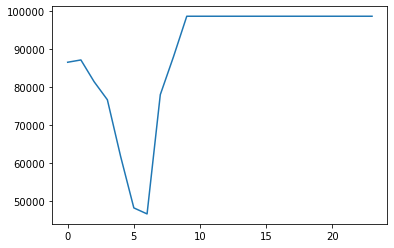

In [16]:
plt.plot(portfolio_value);

In [17]:
max(portfolio_value)

98722.62309999995

In [20]:
state = train_sim.reset()

In [25]:
for i in range(10):
    state = state.reshape(1,-1)
    print(agent.model.predict(state)[0].squeeze())
    action = agent.act(state)
    next_state, reward, done, info = train_sim.step(action)
    next_state = scaler.transform([next_state])
    state = next_state

[1.000000e+00 3.042883e-13 7.365533e-14]
[1.0000000e+00 4.0959776e-19 5.0828909e-17]
[1.0000000e+00 4.6766114e-19 5.4014702e-17]
[1.0000000e+00 1.2522562e-19 2.9424697e-17]
[1.0000000e+00 1.1539141e-19 2.6279713e-17]
[1.0000000e+00 2.4940594e-19 3.8311512e-17]
[1.0000000e+00 3.8779938e-19 4.1688407e-17]
[1.0000000e+00 7.8146606e-19 4.9469963e-17]
[1.0000000e+00 1.7060455e-18 6.5970486e-17]
[1.0000000e+00 7.6770375e-17 5.6712212e-16]
